In [12]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from mpltools import style
from mpltools import layout
%matplotlib inline

In [8]:
#present day
rotation_model_Phanerozoic = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
topology_features_Ceno_Meso = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz'
coastlines = '/Users/Andrew/Documents/EarthByte_Models/Matthews++_410-0Ma/StaticGeometries/Coastlines/Global_coastlines_2015_v1_low_res.gpml'

In [3]:
num_time_steps_PD = 1
num_time_steps_Ceno_Meso = 250
num_time_steps_Palaeozoic = 410

In [13]:
# for present day
Ridge_length_PD = []
Trench_length_PD = []
Fault_length_PD = []
Boundary_total_PD = []
for time in range(0 ,num_time_steps_PD + 0,1):

    # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
    # We generate both the resolved topology boundaries and the boundary sections between them.
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features_Ceno_Meso, rotation_model_Phanerozoic, resolved_topologies, time, shared_boundary_sections)

    # We will accumulate the total ridge and subduction zone lengths for the current 'time'.
    total_ridge_length = 0
    total_subduction_zone_length = 0
    total_fault_length = 0

    # Iterate over the shared boundary sections.
    for shared_boundary_section in shared_boundary_sections:
        
        # Skip sections that are not ridges or subduction zones.
        if (shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.gpml_subduction_zone and
            shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.gpml_mid_ocean_ridge and
            shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.gpml_transform):
            continue

        # Iterate over the shared sub-segments to accumulate their lengths.
        shared_sub_segments_length = 0
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

            # Each sub-segment has a polyline with a length.
            shared_sub_segments_length += shared_sub_segment.get_resolved_geometry().get_arc_length()

        # The shared sub-segments contribute either to the ridges or to the subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            total_ridge_length += shared_sub_segments_length
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            total_subduction_zone_length += shared_sub_segments_length
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            total_fault_length += shared_sub_segments_length
        
    # The lengths are for a unit-length sphere so we must multiple by the Earth's radius.
    total_ridge_length_in_kms = total_ridge_length * pygplates.Earth.mean_radius_in_kms
    total_subduction_zone_length_in_kms = total_subduction_zone_length * pygplates.Earth.mean_radius_in_kms
    total_fault_length_in_kms = total_fault_length * pygplates.Earth.mean_radius_in_kms
    total_boundary_length_in_kms = (total_fault_length_in_kms+total_ridge_length_in_kms+total_subduction_zone_length_in_kms)
    Ridge_length_PD.append(total_ridge_length_in_kms)
    Trench_length_PD.append(total_subduction_zone_length_in_kms)
    Fault_length_PD.append(total_fault_length_in_kms)
    Boundary_total_PD.append(total_boundary_length_in_kms)
    
    #print "At time %dMa, total ridge length is %f kms, total fault length is %f kms and total subduction zone length is %f kms." % (
    #        time, total_ridge_length_in_kms, total_fault_length_in_kms, total_subduction_zone_length_in_kms)
    
    print "At time %dMa, total boundary length is %f kms" % (
            time, total_boundary_length_in_kms)

At time 0Ma, total boundary length is 181728.615166 kms


In [8]:
Trench_length_PD

[57389.42771262046]

ArgumentError: Python argument types in
    DateLineWrapper.wrap(DateLineWrapper, ReconstructedFeatureGeometry, int)
did not match C++ signature:
    wrap(GPlatesMaths::DateLineWrapper, GPlatesUtils::non_null_intrusive_ptr<GPlatesMaths::GeometryOnSphere const, GPlatesUtils::NullIntrusivePointerHandler> geometry, boost::optional<double> tessellate_degrees=None)

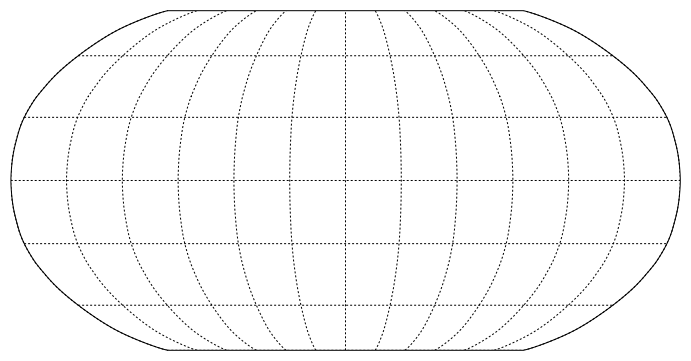

In [17]:
#extract and plot data for 410-250
date_line_wrapper = pygplates.DateLineWrapper() #dateline wrapper for plotting


time = 0

resolved_topologies = []
shared_boundary_sections = []
all_tesselated_shared_sub_segment = []
continental_arcs = []
reconstructed_COBs = []
reconstructed_rifts = []
reconstructed_cratons = []

#resolve/reconstruct our topologies, rifts, supercontinents etc. at the desired time
pygplates.resolve_topologies(topology_features_Ceno_Meso, rotation_model_Phanerozoic, resolved_topologies, time, shared_boundary_sections)
pygplates.reconstruct(coastlines, rotation_model_Phanerozoic, reconstructed_cratons, time)


#set basemape for plotting reconstructions
fig = plt.figure(figsize=(12,8))
m1 = Basemap(resolution='c',projection='robin',lon_0=0.)
clip_path = m1.drawmapboundary()
m1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,0], fontsize=10)
m1.drawparallels(np.arange(-90, 90, 30), labels=[0,0,0,0], fontsize=10)
ax = plt.gca()



for pg in reconstructed_cratons:

    wrapped_polygons_lat = []
    wrapped_polygons_lon = []
    wrapped_polygons = date_line_wrapper.wrap(pg, 1)
    #for wrapped_polygon in wrapped_polygons:
    for wrapped_point in wrapped_polygons.get_exterior_points():
        wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
        wrapped_polygons_lat.append(wrapped_point.get_latitude())
        wrapped_polygons_lon.append(wrapped_point.get_longitude())

    x_geom, y_geom = m1(wrapped_polygons_lon, wrapped_polygons_lat)
    m1.plot(x_geom, y_geom, '#84a79f', linewidth=2,zorder=0)
    plt.fill(x_geom, y_geom, '#84a79f', edgecolor='r', fill=True, alpha=0.7,zorder=0)


In [ ]:


for crat in reconstructed_cratons:
    crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
    wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
    for wrapped_craton in wrapped_cratons:
        wrapped_cratons_lat = []
        wrapped_cratons_lon = []
        for wrapped_craton_point in wrapped_craton.get_exterior_points():
            wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
            wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
            wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

        x_geom_crat, y_geom_crat = m1(wrapped_cratons_lon, wrapped_cratons_lat)
        m1.plot(x_geom_crat, y_geom_crat, 'k', linewidth=1,zorder=0)
        plt.fill(x_geom_crat, y_geom_crat, 'k', edgecolor='r', fill=True, alpha=0.2,zorder=0)


# Proximity Test
#we extact continents above and below our distance threshold to show what *isn't* considered
#continent-margin arc
sz_lons = []
sz_lats = []
sz_lons_non = []
sz_lats_non = []
distance_kms = 100
distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms

for shared_boundary_section in shared_boundary_sections:

    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

            all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)
            count = 0
            for segment in tesselated_shared_sub_segment.get_segments():

                for pg2 in contour_polygons:

                    if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:

                        pg3 = pg2

                        distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                               pg3,
                                                                               distance_threshold_radians,
                                                                               geometry2_is_solid=True)
                        #print count, distance_radians



                        if distance_radians is not None:

                            sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                            sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                            #break

                        if distance_radians is None:
                            sz_lons_non.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                            sz_lats_non.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                            #break

                        count += 1


            sz_lons_plot_non,sz_lats_plot_non = m1(sz_lons_non,sz_lats_non)
            m1.scatter(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', s=1)

            sz_lons_plot,sz_lats_plot = m1(sz_lons,sz_lats)
            m1.scatter(sz_lons_plot,sz_lats_plot, color='#853a2b')                


rift_points = []
rift_lats = []
rift_lons = [] 
for rift in reconstructed_rifts:
    if (rift.get_feature().get_valid_time()[0] > time) and (time > int(rift.get_feature().get_valid_time()[1]) ):
        rift_polyline = rift.get_reconstructed_geometry()
        tmp1 = rift_polyline.to_tessellated(np.radians(0.1))
        for rift_seg in tmp1.get_segments():
            rift_lons.append(rift_seg.get_arc_point(0.5).to_lat_lon()[1])
            rift_lats.append(rift_seg.get_arc_point(0.5).to_lat_lon()[0])
        x_rift,y_rift = m1(rift_lons,rift_lats)
        m1.scatter(x_rift,y_rift,color='#d1680e')#, linewidth=3)
        rift_points.append(tmp1.to_lat_lon_list())

cont_rift = mpatches.Patch(color='#d1680e', label='Continental Rifts')
cont_sz = mpatches.Patch(color='#853a2b', label='Continental Margin Subduction Zone')
oceanic_sz = mpatches.Patch(color='#4682b4', label='Oceanic Subduction Zone')

#plot maps with titles 
#plt.title('%0.2f Ma' % (time), fontsize=20)
#plt.tight_layout()
#plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1), handles=[cont_rift, cont_sz, oceanic_sz], fontsize=15)


#assigned_point_feature_collection = pygplates.FeatureCollection(contour_polygons)
#assigned_point_feature_collection.write(contour_polygons)

#Check for existing output directory and create it if not found
if not os.path.exists('%s/output/snapshots/Figure' % basedir_save):
    os.makedirs('%s/output/snapshots/Figure' % basedir_save)
#
##Check for existing output file with same name and remove if found
if os.path.isfile('%soutput/snapshots/Figure/%s' % (basedir_save, time)):
    os.remove('%soutput/snapshots/Figure/%s' % (basedir_save, time))

plt.savefig('%soutput/snapshots/Figure/%s.png' % (basedir_save, time), bbox_inches='tight', dpi=300)